In [14]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [15]:
train_data = pd.read_csv('pp5i_train.gr.csv')
test_data = pd.read_csv('pp5i_test.gr.csv')
class_data = pd.read_csv('pp5i_train_class.txt')


In [16]:
class_np = class_data.to_numpy()

encoder = preprocessing.LabelEncoder()
encoder.fit(class_np)
label_data = encoder.transform(class_np)

### Data Cleaning

In [17]:
ttdf_sno=train_data['SNO']
ttdf_rem=train_data.iloc[:,1:]

# Threshold both train and test data to a minimum value of 20, maximum of 16,000.

ttdf_rem=ttdf_rem.clip(20,16000)

tsdf_sno=test_data['SNO']
tsdf_rem=test_data.iloc[:,1:]
tsdf_rem=tsdf_rem.clip(20,16000)


#Remove from train data genes with fold differences across samples less than 2.
#Fold difference is defined as a ratio between maximum and minimum values
#(Max/Min) for a given data set

ttdf_cal = ttdf_rem.max(axis=1)/ttdf_rem.min(axis=1)
ttdf_cal = abs(ttdf_cal)
del_ind = ttdf_cal[ttdf_cal<2].index

train_tdf = pd.concat([ttdf_sno.drop(del_ind),ttdf_rem.drop(del_ind)],axis=1,sort=False)
test_tdf = pd.concat ([tsdf_sno.drop(del_ind),tsdf_rem.drop(del_ind)],axis=1,sort=False)



## Selecting top genes by class


 Training Data:  
                  SNO    1   2    3    4    5    6   7    8   9  ...   61   62  \
2506       U00921_at   20  20   20   20   20   20  20   20  20  ...   26   20   
6528     U59877_s_at   20  45   20   20   20   20  20   20  20  ...  285  341   
6663   AF000424_s_at   20  20   20   20   20   20  20   20  20  ...   20   20   
5503     D13631_s_at   21  54   20   31   20   20  20   20  20  ...  114  141   
3688       U79242_at   20  20   20   20   32   20  20   20  20  ...   31   20   
...              ...  ...  ..  ...  ...  ...  ...  ..  ...  ..  ...  ...  ...   
6861  X54489_rna1_at   20  20   20   20   20   20  20   20  20  ...   20   20   
1241       L13042_at   50  53   48   42   40   43  61   30  26  ...   41   36   
1658  M14159_cds2_at   48  85  108   27   54   46  24   20  20  ...   82   78   
3355       U56816_at  122  73   79  120  151  119  67  100  40  ...   74  103   
4156       X51757_at   20  20   20   21   20   20  27   20  20  ...   52   20   

       6

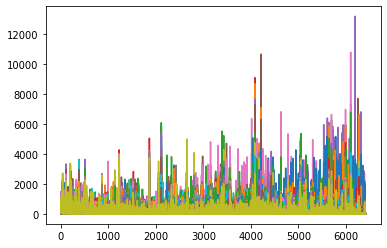

In [18]:
from sklearn.feature_selection import f_classif

#feature selection part
tTrain_tdf = train_tdf.T[1:]
new_train = f_classif(tTrain_tdf,label_data)
train_tdf['rank']=new_train[0]
test_tdf['rank']=new_train[0]

#sorting data based on rank 
train_tdf=train_tdf.sort_values('rank',ascending=False)
test_tdf=test_tdf.sort_values('rank',ascending=False)

print("\033[4m Training Data: \033[0m \n",train_tdf,"\n")
print("\033[4m Testing Data: \033[0m \n",test_tdf,"\n")

training_data = train_tdf.drop('SNO',axis=1)
training_data = training_data.drop('rank',axis=1)
training_data = training_data.to_numpy()

p=plt.plot(training_data)

In [19]:
import numpy as np
from numpy import savetxt
from numpy import genfromtxt

def unique_rows(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return a[ui]

NList = [2,4,6,8,10,12,15,20,25,30]

#saving data with all with top N=2, 4, 6, 8, 10, 12, 15, 20,25, 30 genes 

for N in NList:
    x_train = train_tdf.drop('SNO',axis=1)
    x_train = x_train.drop('rank',axis=1)
    x_train = x_train.to_numpy()
    x_train = x_train[:N].T
    x_trainN = np.c_[x_train, label_data]
    x_trainN=unique_rows(x_trainN)

    filename="pp5i_train.top"+str(N)+".gr.csv"
    savetxt(filename, x_trainN, delimiter=',')

## Find the best classifier/best gene set combination

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

arr = np.zeros((10,6))
row =0 


for N in NList:
    NRow = list()
    NRow.append(N)

    col =0
    arr[row][col]=N

    filename="pp5i_train.top"+str(N)+".gr.csv"
    data_arr = np.genfromtxt(filename,delimiter=',') 
    x_trainNT = data_arr[:,:-1]
    y_trainNT = data_arr[:,-1]
    
    #GaussianNB classifier
    gaussian_clf = GaussianNB()
    
    #KNeighborsClassifier
    knn_clf = KNeighborsClassifier(n_neighbors=3)
    
    #DecisionTreeClassifier
    decision_tree_clf = DecisionTreeClassifier(max_depth=6)
    
    #NeuralNetwork Classifier
    neural_network_clf = MLPClassifier(activation = 'relu', solver = 'sgd', hidden_layer_sizes= (25, 25),random_state = 5, max_iter=250)
    
    #Support vector machine classifier
    svm_clf = SVC(C=1.0, random_state=1, kernel='linear')
    
    

    gaussian_clf.fit(x_trainNT,y_trainNT)
    knn_clf.fit(x_trainNT,y_trainNT)
    decision_tree_clf.fit(x_trainNT,y_trainNT)
    neural_network_clf.fit(x_trainNT,y_trainNT)
    svm_clf.fit(x_trainNT,y_trainNT)

    from sklearn.model_selection import cross_val_score
    
    print("N =" ,N)
    
    
    scores = cross_val_score(gaussian_clf, x_trainNT, y_trainNT,cv=5)
    NRow.append(scores.mean())
    col+=1
    arr[row][col]=1-scores.mean()  
    
    print('gaussian_clf accuaracy:',scores.mean())
    
    scores = cross_val_score(knn_clf, x_trainNT, y_trainNT,cv=5)
    NRow.append(scores.mean())
    col+=1 
    arr[row][col]=1-scores.mean()  
    
    
    print('knn_clf accuaracy:',scores.mean())
    
    scores = cross_val_score(decision_tree_clf, x_trainNT, y_trainNT,cv=5)
    NRow.append(scores.mean())
    col+=1
    arr[row][col]=1-scores.mean()  
    
    print('decision_tree_clf accuaracy:',scores.mean())
    
    scores = cross_val_score(neural_network_clf, x_trainNT, y_trainNT,cv=5)
    NRow.append(scores.mean())
    col+=1
    arr[row][col]=1-scores.mean()  
    
    print('neural_network_clf accuaracy:',scores.mean())
   
    scores = cross_val_score(svm_clf, x_trainNT, y_trainNT,cv=5)
    NRow.append(scores.mean())
    col+=1
    arr[row][col]=1-scores.mean()  
    
    print('svm_clf accuaracy:',scores.mean(),'\n')
    
    
    row+=1
    


N = 2
gaussian_clf accuaracy: 0.48571428571428565
knn_clf accuaracy: 0.45714285714285713
decision_tree_clf accuaracy: 0.5238095238095238
neural_network_clf accuaracy: 0.2619047619047619
svm_clf accuaracy: 0.3857142857142857 

N = 4
gaussian_clf accuaracy: 0.37499999999999994
knn_clf accuaracy: 0.4107142857142857
decision_tree_clf accuaracy: 0.4214285714285714
neural_network_clf accuaracy: 0.4107142857142857
svm_clf accuaracy: 0.4428571428571429 

N = 6
gaussian_clf accuaracy: 0.39999999999999997
knn_clf accuaracy: 0.44444444444444436
decision_tree_clf accuaracy: 0.4666666666666666
neural_network_clf accuaracy: 0.31111111111111106
svm_clf accuaracy: 0.5111111111111111 

N = 8
gaussian_clf accuaracy: 0.48791208791208796
knn_clf accuaracy: 0.7791208791208792
decision_tree_clf accuaracy: 0.7516483516483516
neural_network_clf accuaracy: 0.7230769230769231
svm_clf accuaracy: 0.8252747252747252 

N = 10
gaussian_clf accuaracy: 0.4164835164835165
knn_clf accuaracy: 0.7681318681318682
decision_

In [21]:
CList = ["GaussianNB","DecisionTreeClassifier","KNeighborsClassifier","MLP","SVC"]
NMList = list()
for i in arr[:,1:]:
    print(i)
    NMList.append(np.mean(i))

CMList = list()
for i in range(arr.shape[1]-1):
  CMList.append(np.mean(arr[:,i+1]))
  
maxN = min(NMList)
mi=[i for i, j in enumerate(NMList) if j == maxN]
maxNV = NList[mi[0]]

maxC = min(CMList)
mi=[i for i, j in enumerate(CMList) if j == maxC]
maxCV = CList[mi[0]]

filename="pp5i_train.top"+str(maxNV)+".gr.csv"
data_arr = np.genfromtxt(filename,delimiter=',') 
best_genes_set = data_arr[:,:-1]
best_genes_cls = data_arr[:,-1]
filename="pp5i_train.bestN.csv"
savetxt(filename, best_genes_set, delimiter=',')

x_test = test_tdf.drop('SNO',axis=1)
x_test = x_test.drop('rank',axis=1)
x_test = x_test.to_numpy()
x_test = x_test[:maxNV].T
filename="pp5i_test.bestN.csv"
savetxt(filename, x_test, delimiter=',')

[0.51428571 0.54285714 0.47619048 0.73809524 0.61428571]
[0.625      0.58928571 0.57857143 0.58928571 0.55714286]
[0.6        0.55555556 0.53333333 0.68888889 0.48888889]
[0.51208791 0.22087912 0.24835165 0.27692308 0.17472527]
[0.58351648 0.23186813 0.25934066 0.34835165 0.24505495]
[0.49120879 0.15934066 0.23406593 0.33296703 0.27912088]
[0.33296703 0.14395604 0.22527473 0.27362637 0.04505495]
[0.39230769 0.1010989  0.13406593 0.26263736 0.04395604]
[0.26703297 0.05824176 0.05824176 0.41978022 0.02967033]
[0.24835165 0.08571429 0.1010989  0.27582418 0.01428571]


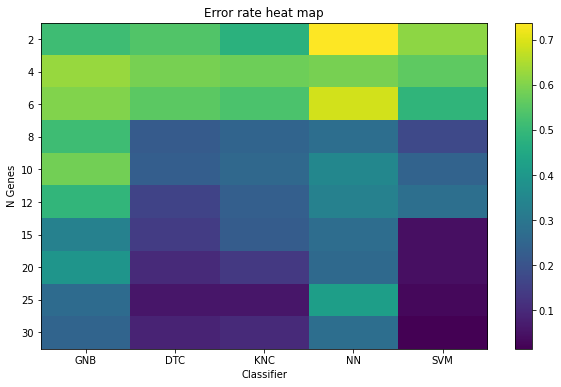

In [40]:
import matplotlib.pyplot as plt
cdict = {0: 'indigo',1: 'magenta', 2: 'blue', 3: 'green', 4: 'red'}

plt.figure(figsize = (10,6))

hm=plt.imshow(arr[:,1:],aspect='auto')
cb=plt.colorbar()

xlocs, xlabels=plt.xticks()
ylocs, ylabels=plt.yticks()

new_xlocs=[0,1,2,3,4]
new_xlabels=['GNB','DTC','KNC','NN','SVM']
# new_xlabels=CList
xt = plt.xticks(new_xlocs,new_xlabels)

new_ylocs=[0,1,2,3,4,5,6,7,8,9]

new_ylabels=NList
yt = plt.yticks(new_ylocs,new_ylabels)

titl = plt.title("Error rate heat map")
yl = plt.ylabel("N Genes")
yl = plt.xlabel("Classifier")

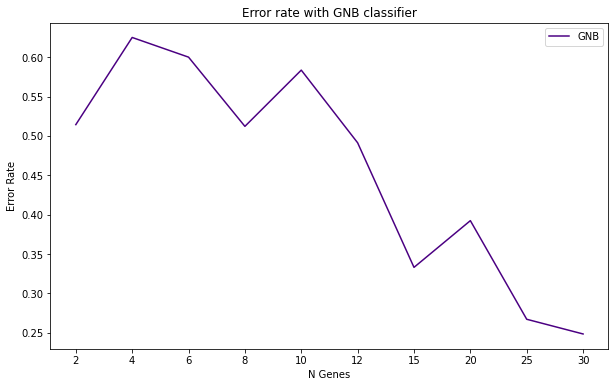

In [41]:
err_arr = arr[:,1:]

plt.figure(figsize = (10,6))
plt.plot(err_arr[:,0],c = cdict[0], label = new_xlabels[0])
lg = plt.legend()
xt = plt.xticks([0,1,2,3,4,5,6,7,8,9],new_ylabels)
titl = plt.title("Error rate with "+ new_xlabels[0]+" classifier")
yl = plt.xlabel("N Genes")
yl = plt.ylabel("Error Rate")

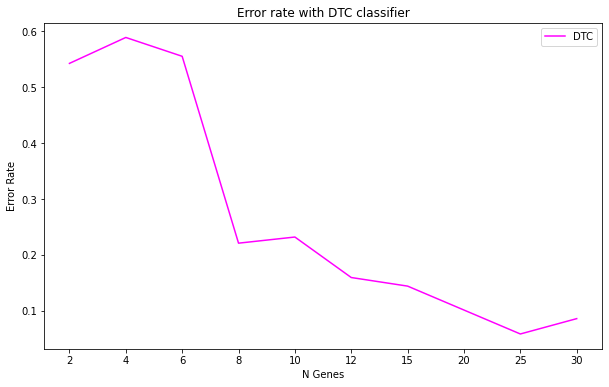

In [42]:
err_arr = arr[:,1:]

plt.figure(figsize = (10,6))
plt.plot(err_arr[:,1],c = cdict[1], label = new_xlabels[1])
lg = plt.legend()
xt = plt.xticks([0,1,2,3,4,5,6,7,8,9],new_ylabels)
titl = plt.title("Error rate with "+ new_xlabels[1]+" classifier")
yl = plt.xlabel("N Genes")
yl = plt.ylabel("Error Rate")

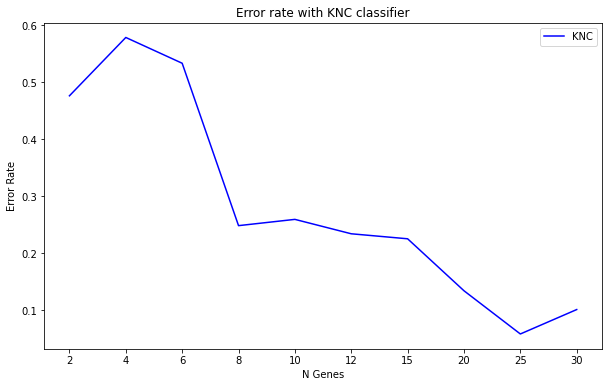

In [44]:
err_arr = arr[:,1:]

plt.figure(figsize = (10,6))
plt.plot(err_arr[:,2],c = cdict[2], label = new_xlabels[2])
lg = plt.legend()
xt = plt.xticks([0,1,2,3,4,5,6,7,8,9],new_ylabels)
titl = plt.title("Error rate with "+ new_xlabels[2]+" classifier")
yl = plt.xlabel("N Genes")
yl = plt.ylabel("Error Rate")

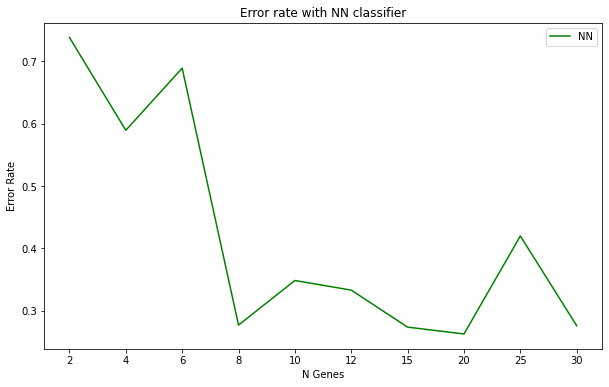

In [45]:
err_arr = arr[:,1:]

plt.figure(figsize = (10,6))
plt.plot(err_arr[:,3],c = cdict[3], label = new_xlabels[3])
lg = plt.legend()
xt = plt.xticks([0,1,2,3,4,5,6,7,8,9],new_ylabels)
titl = plt.title("Error rate with "+ new_xlabels[3]+" classifier")
yl = plt.xlabel("N Genes")
yl = plt.ylabel("Error Rate")

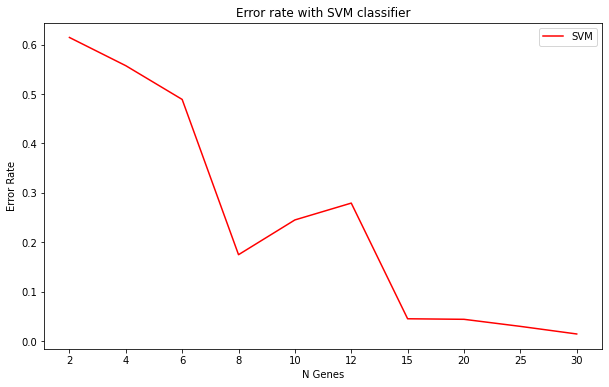

In [46]:
err_arr = arr[:,1:]

plt.figure(figsize = (10,6))
plt.plot(err_arr[:,4],c = cdict[4], label = new_xlabels[4])
lg = plt.legend()
xt = plt.xticks([0,1,2,3,4,5,6,7,8,9],new_ylabels)
titl = plt.title("Error rate with "+ new_xlabels[4]+" classifier")
yl = plt.xlabel("N Genes")
yl = plt.ylabel("Error Rate")

## Best classifier 

In [24]:
classifier_desired = maxCV
classifier_desired

'SVC'

## Generate predictions for the test set

In [25]:
filename="pp5i_train.bestN.csv"
data_arr = np.genfromtxt(filename,delimiter=',') 
x_trainNT = data_arr
y_trainNT = best_genes_cls

clf = SVC(C=1.0, random_state=1, kernel='linear')

clf.fit(x_trainNT,y_trainNT)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x_trainNT, y_trainNT,cv=5)

print("Best N         : ",maxNV)
print("Best Clasifier : ",maxCV)
print("Best Accuracy  : ",np.mean(scores))

Best N         :  30
Best Clasifier :  SVC
Best Accuracy  :  0.9857142857142858


In [26]:
filename="pp5i_test.bestN.csv"
x_testN = np.genfromtxt(filename,delimiter=',') 

num_out = clf.predict(x_testN)

test_class = encoder.inverse_transform(num_out.astype(int))
print("Test dataset predictions :\n",test_class)

Test dataset predictions :
 ['MGL' 'EPD' 'MED' 'MED' 'EPD' 'MED' 'MED' 'MED' 'EPD' 'JPA' 'JPA' 'MED'
 'MED' 'MED' 'MED' 'MED' 'MGL' 'MED' 'RHB' 'RHB' 'RHB' 'MED' 'RHB']


## Generate a prediction using Adaptive Boosting

In [27]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(abc, x_trainNT, y_trainNT,cv=5)
print("Mean Accuracy  : ",np.mean(scores))

Mean Accuracy  :  0.8274725274725275


In [28]:
x_testN = np.genfromtxt(filename,delimiter=',') 


abc.fit(x_trainNT,y_trainNT)

num_out = abc.predict(x_testN)

test_class = encoder.inverse_transform(num_out.astype(int))
print("Test dataset predictions :\n",test_class)

Test dataset predictions :
 ['MED' 'EPD' 'MED' 'MED' 'EPD' 'MED' 'MED' 'MED' 'EPD' 'EPD' 'JPA' 'MED'
 'MED' 'MED' 'MED' 'MED' 'EPD' 'MED' 'MED' 'EPD' 'EPD' 'MED' 'MED']
